## Understanding the Data

In [16]:
"""
ADHD Prediction Dataset - Data Preprocessing Module

This notebook performs comprehensive data preprocessing on the merged ADHD dataset,
including data quality assessment, outlier detection, feature engineering, and 
data transformation for machine learning models.


Project: ADHD Sex Prediction
Input: Raw merged dataset from Data Merging module
Output: Preprocessed dataset ready for modeling
"""

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import joblib
import json
from imblearn.over_sampling import ADASYN

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# File paths
RAW_DATA_PATH = r"C:\Users\04ama\Downloads\raw adhd data\raw_dataset.csv"
QUANT_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_QUANTITATIVE_METADATA_new.xlsx"
CAT_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_CATEGORICAL_METADATA_new.xlsx"
CONN_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson (1).csv"

# Preprocessing parameters
PCA_COMPONENTS = 10
KNN_NEIGHBORS = 5
OUTLIER_METHOD = 'IQR'  # Interquartile Range method
OUTLIER_MULTIPLIER = 1.5


In [17]:
# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

def load_preprocessing_data():
    """
    Load all datasets required for preprocessing analysis.
    
    Returns:
    --------
    tuple
        (main_df, quant_data, cat_data, conn_data) - All loaded datasets
    
    Notes:
    ------
    - Main dataset is the merged output from Data Merging module
    - Individual datasets used for distribution analysis and validation
    """

    
    # Load main merged dataset
    print("Loading merged dataset")
    df = pd.read_csv(RAW_DATA_PATH)

    
    # Load individual datasets for analysis
    print(" Loading individual datasets for comparison ")
    quant_data = pd.read_excel(QUANT_DATA_PATH)
    cat_data = pd.read_excel(CAT_DATA_PATH)
    conn_data = pd.read_csv(CONN_DATA_PATH)

    print(f"Quantitative data shape: {quant_data.shape}")
    print(f"Categorical data shape: {cat_data.shape}")
    print(f"Connectome data shape: {conn_data.shape}")

    return df, quant_data, cat_data, conn_data

# Load all datasets
df, quant_data, cat_data, conn_data = load_preprocessing_data()

Loading merged dataset
 Loading individual datasets for comparison 
Quantitative data shape: (1213, 19)
Categorical data shape: (1213, 10)
Connectome data shape: (1213, 19901)


In [18]:
# =============================================================================
# DATA QUALITY ASSESSMENT
# =============================================================================

def assess_data_quality(df):
    """
    Comprehensive data quality assessment including missing values analysis.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to assess
    
    Returns:
    --------
    dict
        Quality assessment report
    """
 
    # Overall statistics
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    sparsity_percentage = (missing_cells / total_cells) * 100
    
    print(f" Overall Data Quality:")
    print(f"  Dataset shape: {df.shape}")
    print(f"  Total cells: {total_cells:,}")
    print(f"  Missing cells: {missing_cells:,}")
    print(f"  Overall sparsity: {sparsity_percentage:.4f}%")
    
    # Identify column types for targeted analysis
    quant_cols = [col for col in df.columns if 
                  col.startswith('APQ_') or col.startswith('SDQ_') or 
                  col.startswith('EHQ_') or col.startswith('ColorVision')]
    
    cat_cols = [col for col in df.columns if 
                col.startswith('PreInt_') or col.startswith('Basic_') or col.startswith('Sex_')]
    
    conn_cols = [col for col in df.columns if 
                 col not in quant_cols + cat_cols + 
                 ['participant_id', 'ADHD_Outcome']]
    
    # Missing values by column type
    print(f"\n Missing Values by Feature Type:")
    
    quant_missing = df[quant_cols].isnull().sum().sum()
    quant_total = len(quant_cols) * df.shape[0]
    quant_pct = (quant_missing / quant_total) * 100 if quant_total > 0 else 0
    print(f" Quantitative: {quant_missing:,}/{quant_total:,} ({quant_pct:.2f}%)")
    
    cat_missing = df[cat_cols].isnull().sum().sum()
    cat_total = len(cat_cols) * df.shape[0]
    cat_pct = (cat_missing / cat_total) * 100 if cat_total > 0 else 0
    print(f" Categorical: {cat_missing:,}/{cat_total:,} ({cat_pct:.2f}%)")
    
    conn_missing = df[conn_cols].isnull().sum().sum()
    conn_total = len(conn_cols) * df.shape[0]
    conn_pct = (conn_missing / conn_total) * 100 if conn_total > 0 else 0
    print(f" Connectome: {conn_missing:,}/{conn_total:,} ({conn_pct:.2f}%)")
    
    # Identify columns with highest missing values
    print(f"\n Columns with Most Missing Values:")
    missing_by_col = df.isnull().sum().sort_values(ascending=False)
    high_missing = missing_by_col[missing_by_col > 0]
    
    if len(high_missing) > 0:
        for col, missing_count in high_missing.head(10).items():
            missing_pct = (missing_count / df.shape[0]) * 100
            print(f" {col}: {missing_count:,}/{df.shape[0]:,} ({missing_pct:.1f}%)")
    else:
        print(" No missing values found!")
    
    return {
        'quant_cols': quant_cols,
        'cat_cols': cat_cols, 
        'conn_cols': conn_cols,
        'sparsity': sparsity_percentage,
        'missing_by_type': {
            'quantitative': quant_pct,
            'categorical': cat_pct,
            'connectome': conn_pct
        }
    }

    

# Assess data quality
quality_report = assess_data_quality(df)

 Overall Data Quality:
  Dataset shape: (1213, 19930)
  Total cells: 24,175,090
  Missing cells: 1,115
  Overall sparsity: 0.0046%

 Missing Values by Feature Type:
 Quantitative: 189/20,621 (0.92%)
 Categorical: 97/6,065 (1.60%)
 Connectome: 829/24,145,978 (0.00%)

 Columns with Most Missing Values:
 MRI_Track_Age_at_Scan: 360/1,213 (29.7%)
 Barratt_Barratt_P2_Occ: 222/1,213 (18.3%)
 Barratt_Barratt_P2_Edu: 198/1,213 (16.3%)
 PreInt_Demos_Fam_Child_Race: 54/1,213 (4.5%)
 PreInt_Demos_Fam_Child_Ethnicity: 43/1,213 (3.5%)
 Barratt_Barratt_P1_Occ: 31/1,213 (2.6%)
 ColorVision_CV_Score: 23/1,213 (1.9%)
 Barratt_Barratt_P1_Edu: 15/1,213 (1.2%)
 EHQ_EHQ_Total: 13/1,213 (1.1%)
 APQ_P_APQ_P_PM: 12/1,213 (1.0%)


quantitative features histograms


<Figure size 1500x1000 with 0 Axes>

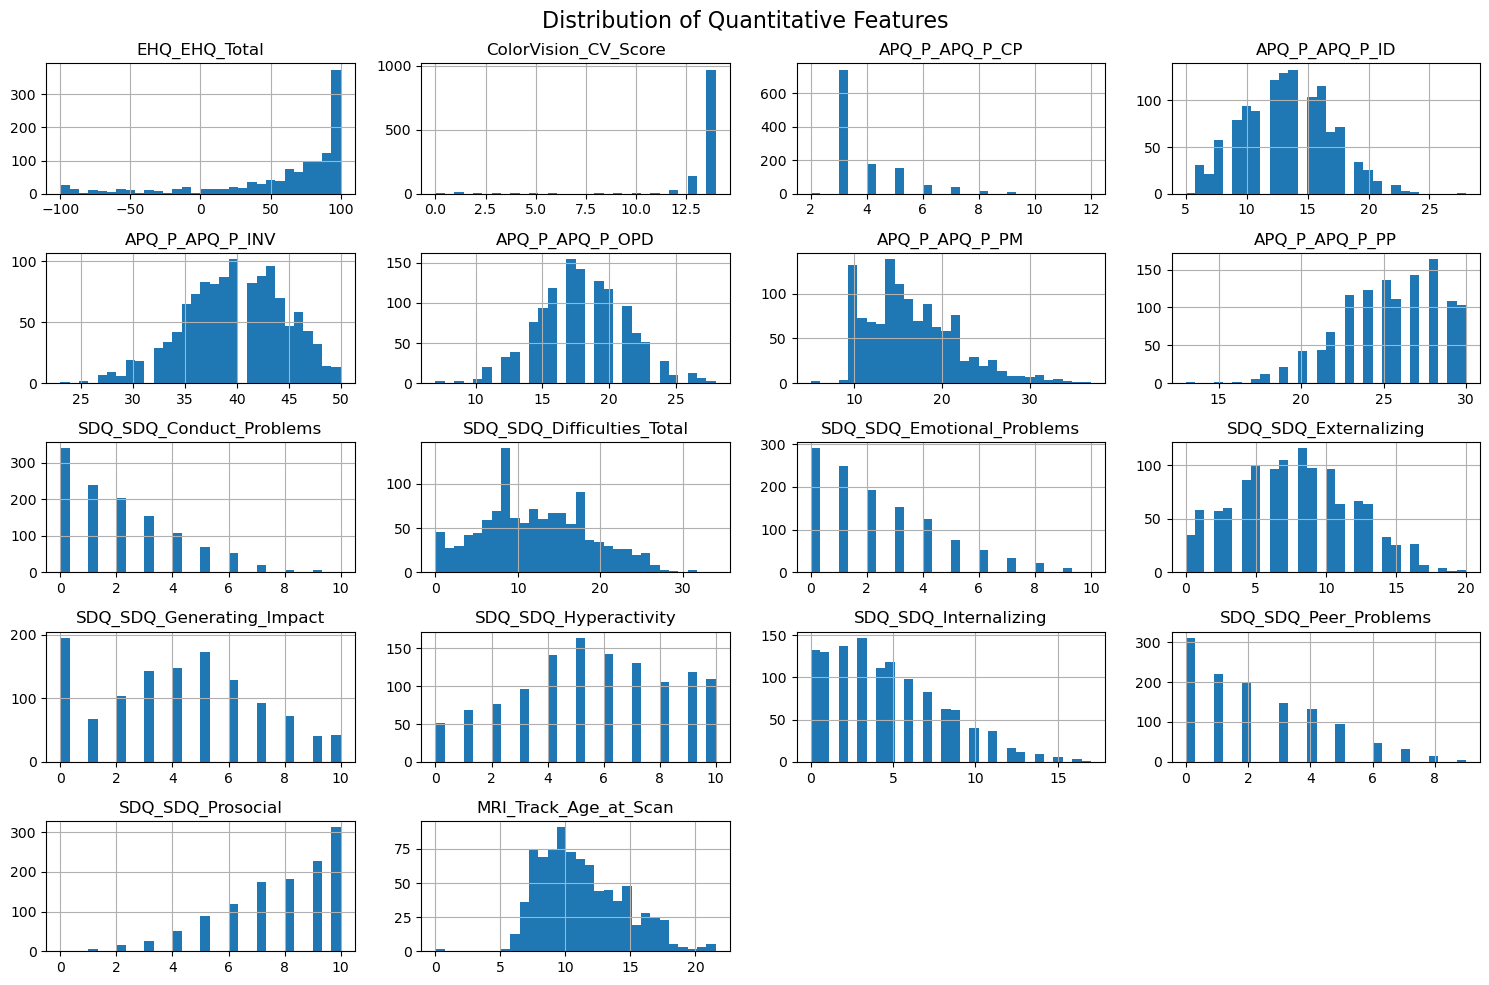

Quantitative features box plots


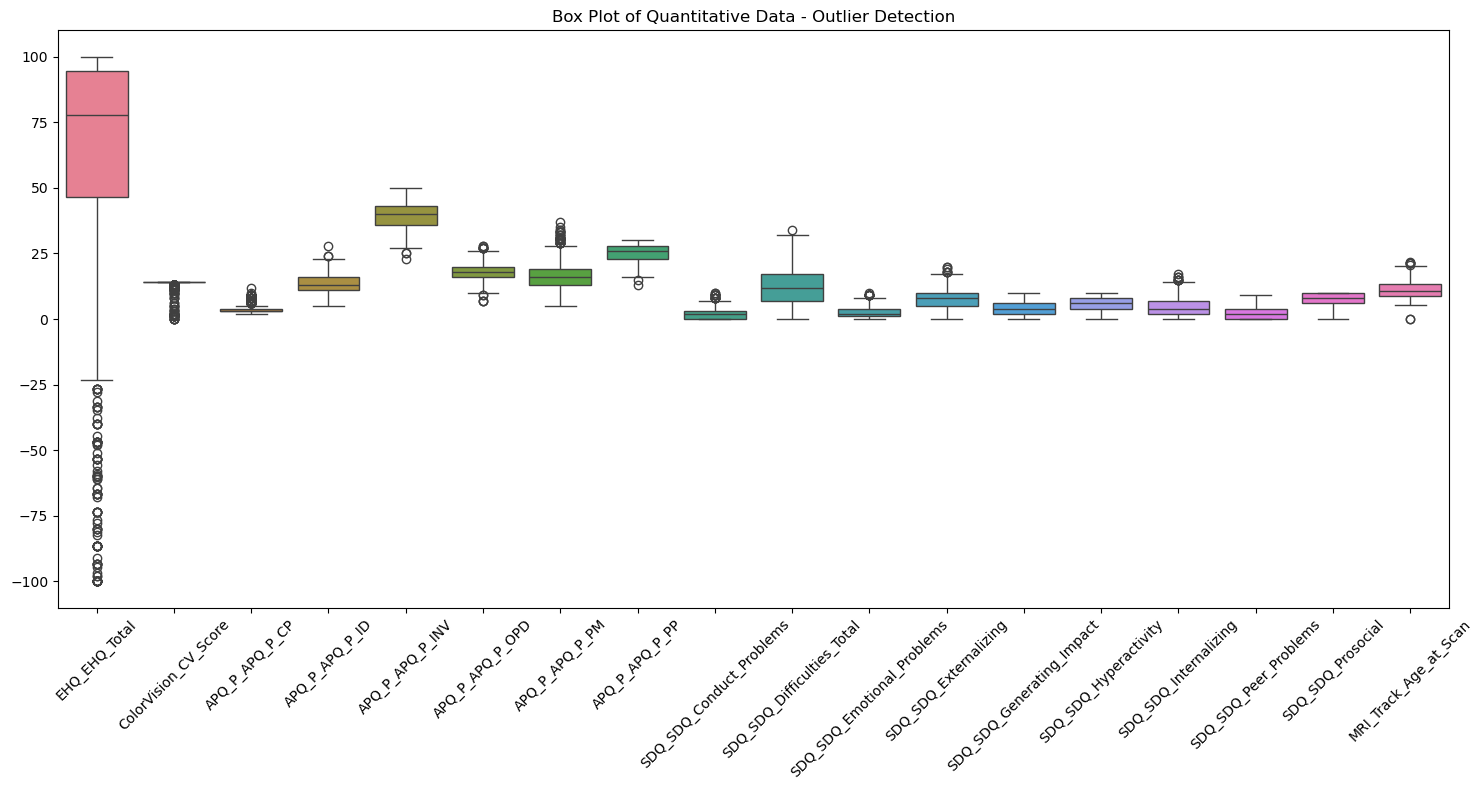

  Visualizing connectome data structure with PCA


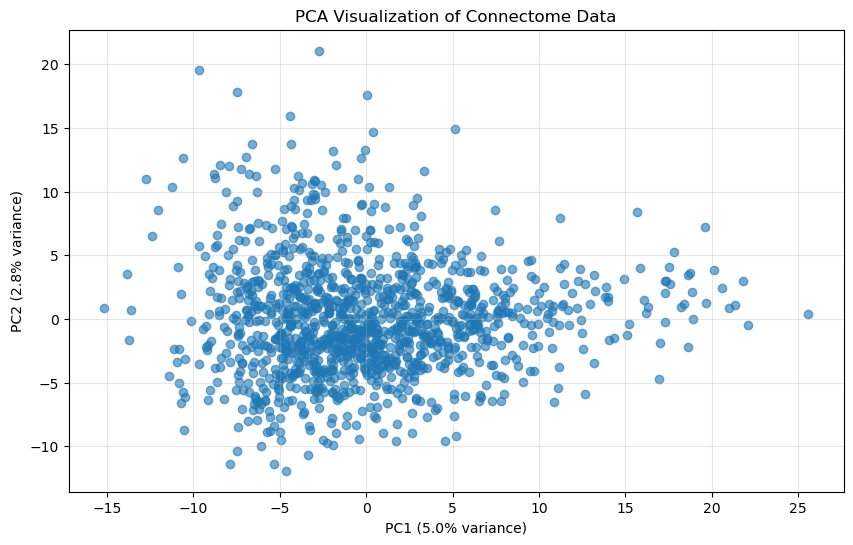

 PCA explains 7.8% of variance in 2 components


In [19]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================

def visualize_feature_distributions(quant_data, conn_data):
    """
    Create visualizations to understand feature distributions.
    
    Parameters:
    -----------
    quant_data : pd.DataFrame
        Quantitative features dataset
    conn_data : pd.DataFrame
        Connectome features dataset
    """

    
    # Quantitative features distribution
    print("quantitative features histograms")
    plt.figure(figsize=(15, 10))
    quant_data_clean = quant_data.drop(columns=['participant_id'], errors='ignore')
    quant_data_clean.hist(bins=30, figsize=(15, 10))
    plt.suptitle("Distribution of Quantitative Features", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Quantitative features outlier detection
    print("Quantitative features box plots")
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=quant_data_clean)
    plt.title("Box Plot of Quantitative Data - Outlier Detection")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Connectome data PCA visualization
    print("  Visualizing connectome data structure with PCA")
    conn_data_clean = conn_data.drop(columns=['participant_id'], errors='ignore')
    
    if conn_data_clean.shape[1] >= 2:
        pca_viz = PCA(n_components=2)
        conn_pca_viz = pca_viz.fit_transform(conn_data_clean)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(conn_pca_viz[:, 0], conn_pca_viz[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('PCA Visualization of Connectome Data')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f" PCA explains {pca_viz.explained_variance_ratio_.sum():.1%} of variance in 2 components")
    else:
        print(" Not enough connectome features for PCA visualization")

        

# Visualize distributions
visualize_feature_distributions(quant_data, conn_data)

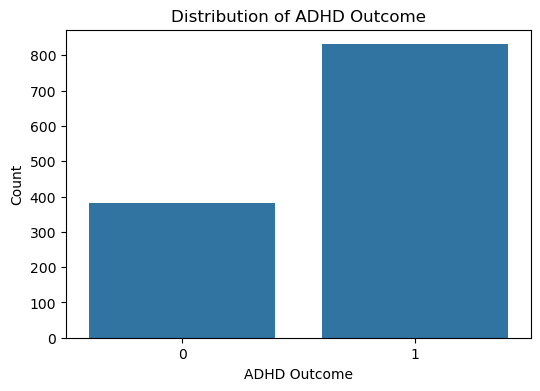

In [20]:
def target_distrbution(df):
    """
    Visualize the distribution of the target variable (ADHD_Outcome).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing the target variable
    """
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='ADHD_Outcome', data=df)
    plt.title("Distribution of ADHD Outcome")
    plt.xlabel("ADHD Outcome")
    plt.ylabel("Count")
    plt.show()

target_distrbution(df)

 Analyzing outliers in: EHQ_EHQ_Total
 Number of outliers: 110
   Creating outlier visualization...


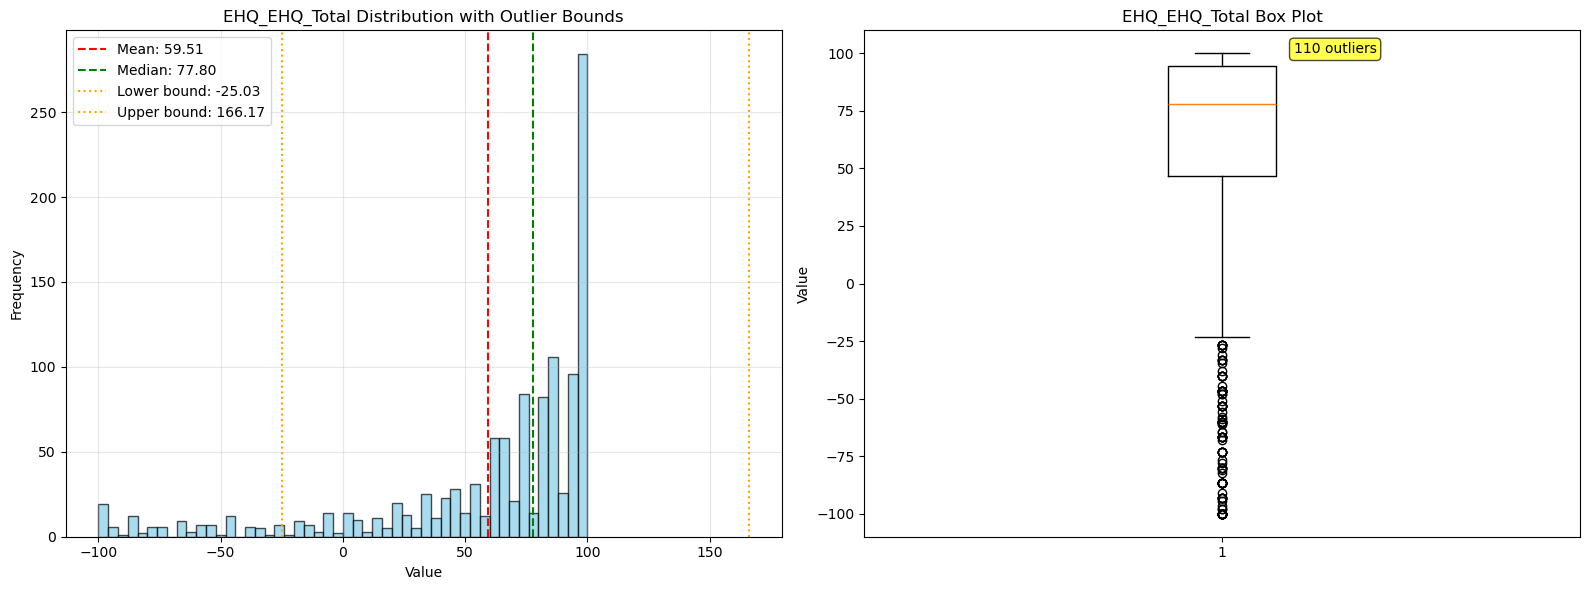

In [21]:
# =============================================================================
# OUTLIER DETECTION AND ANALYSIS
# =============================================================================

def detect_outliers(df, target_column='EHQ_EHQ_Total'):
    """
    Detect outliers using IQR method and analyze their impact.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to analyze
    target_column : str
        Column to analyze for outliers
    
    Returns:
    --------
    tuple
        (outlier_mask, outlier_stats) - Mask for outliers and statistics
    """
 
    
    print(f" Analyzing outliers in: {target_column}")
    
    # Get clean data for analysis
    target_data = df[target_column].dropna()
    
    # Calculate IQR bounds
    Q1 = target_data.quantile(0.25)
    Q3 = target_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - OUTLIER_MULTIPLIER * IQR
    upper_bound = Q3 + OUTLIER_MULTIPLIER * IQR
    
    # Identify outliers
    outlier_mask = (df[target_column] < lower_bound) | (df[target_column] > upper_bound)
    outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]
    
 
    print(f" Number of outliers: {len(outliers):,}")
   
    
    # Visualize outliers
    print("   Creating outlier visualization...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram with bounds
    axes[0].hist(target_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(target_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: {target_data.mean():.2f}')
    axes[0].axvline(target_data.median(), color='green', linestyle='--', 
                   label=f'Median: {target_data.median():.2f}')
    axes[0].axvline(lower_bound, color='orange', linestyle=':', 
                   label=f'Lower bound: {lower_bound:.2f}')
    axes[0].axvline(upper_bound, color='orange', linestyle=':', 
                   label=f'Upper bound: {upper_bound:.2f}')
    axes[0].set_title(f'{target_column} Distribution with Outlier Bounds')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(target_data, vert=True)
    axes[1].set_title(f'{target_column} Box Plot')
    axes[1].set_ylabel('Value')
    axes[1].text(1.1, target_data.max(), f'{len(outliers)} outliers', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return outlier_mask

# Detect outliers
outlier_mask = detect_outliers(df)
df = df[~outlier_mask].reset_index(drop=True)

In [22]:
# =============================================================================
# OUTLIER IMPACT 
# =============================================================================

def outlier_impact(df, outlier_mask, target_col='ADHD_Outcome'):
    """
    Assess the impact of removing outliers on target variable distribution.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataset
    outlier_mask : pd.Series
        Boolean mask identifying outliers
    target_col : str
        Target variable to analyze
    
    Returns:
    --------
    dict
        Statistical test results
    """
    print("🔍 STEP: Outlier Impact Analysis")
    print("-" * 40)
    
    # Create datasets with and without outliers
    df_with_outliers = df.copy()
    df_without_outliers = df[~outlier_mask].copy()
    
    # Compare target distributions
    adhd_with = df_with_outliers[target_col].value_counts().sort_index()
    adhd_without = df_without_outliers[target_col].value_counts().sort_index()
    
    print(f"   📊 Target Distribution Comparison:")
    print(f"      • With outliers: {dict(adhd_with)}")
    print(f"      • Without outliers: {dict(adhd_without)}")
    print(f"      • Samples to remove: {outlier_mask.sum():,}")
    
    # Statistical significance test (Chi-square)
    print(f"   📈 Statistical Significance Test (Chi-square):")
    
    try:
        # Create contingency table
        contingency_table = np.array([
            adhd_with.values,
            [adhd_without.get(i, 0) for i in adhd_with.index]
        ])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        print(f"      • Chi-square statistic: {chi2:.4f}")
        print(f"      • P-value: {p_value:.4f}")
        print(f"      • Degrees of freedom: {dof}")
        
        if p_value < 0.05:
            decision = "Significant difference - removing outliers changes ADHD distribution"
            remove_outliers = False
            print(f"      ⚠️ Decision: {decision}")
        else:
            decision = "No significant difference - safe to remove outliers"
            remove_outliers = True
            print(f"      ✅ Decision: {decision}")
        
        return {
            'chi2': chi2,
            'p_value': p_value,
            'dof': dof,
            'remove_outliers': remove_outliers,
            'samples_removed': outlier_mask.sum(),
            'decision': decision
        }
        
    except ValueError as e:
        print(f"      ❌ Error in Chi-square test: {str(e)}")
        print(f"      🔄 Using conservative approach - keeping outliers")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,  # Conservative approach
            'samples_removed': outlier_mask.sum(),
            'decision': 'Error in statistical test - keeping outliers for safety',
            'error': str(e)
        }
    
    except Exception as e:
        print(f"      ❌ Unexpected error in outlier impact analysis: {str(e)}")
        print(f"      🔄 Using conservative approach - keeping outliers")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,  # Conservative approach
            'samples_removed': outlier_mask.sum(),
            'decision': 'Unexpected error - keeping outliers for safety',
            'error': str(e)
        }

# ✅ FIXED: Assess outlier impact with proper exception handling
try:
    impact_results = outlier_impact(df, outlier_mask)
    
    # Remove outliers if statistically safe
    if impact_results.get('remove_outliers', False):
        print(f"\n✅ Removing {outlier_mask.sum():,} outliers from dataset")
        df = df[~outlier_mask].copy()
        print(f"   📊 New dataset shape: {df.shape}")
        print(f"   📈 Reduction: {outlier_mask.sum()} samples ({(outlier_mask.sum()/len(df)*100):.1f}%)")
    else:
        print(f"\n⚠️ Keeping outliers due to statistical significance")
        print(f"   📊 Dataset shape remains: {df.shape}")
        print(f"   💡 Reason: {impact_results.get('decision', 'Statistical test recommended keeping outliers')}")

except Exception as e:
    print(f"\n❌ Error in outlier impact analysis: {str(e)}")
    print(f"🔄 Proceeding without outlier removal for safety")
    print(f"📊 Dataset shape remains: {df.shape}")

🔍 STEP: Outlier Impact Analysis
----------------------------------------
   📊 Target Distribution Comparison:
      • With outliers: {0: 350, 1: 753}
      • Without outliers: {0: 321, 1: 680}
      • Samples to remove: 110
   📈 Statistical Significance Test (Chi-square):
      • Chi-square statistic: 0.0140
      • P-value: 0.9057
      • Degrees of freedom: 1
      ✅ Decision: No significant difference - safe to remove outliers

✅ Removing 110 outliers from dataset


C:\Users\04ama\AppData\Local\Temp\ipykernel_6588\2991565199.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outliers = df[~outlier_mask].copy()
C:\Users\04ama\AppData\Local\Temp\ipykernel_6588\2991565199.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~outlier_mask].copy()


   📊 New dataset shape: (1001, 19930)
   📈 Reduction: 110 samples (11.0%)


In [23]:
# sorting imbalanced data with ADASYN
# =============================================================================
# CLASS IMBALANCE HANDLING WITH ADASYN
# =============================================================================

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


def experiment_adasyn_neighbors(X, y, neighbor_range=(1, 21), step=2, test_size=0.2, random_state=42):
    """
    Experiment with different n_neighbors values for ADASYN.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector
    neighbor_range : tuple
        Range of neighbors to test (start, end)
    step : int
        Step size for neighbor range
    test_size : float
        Test set proportion
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Experiment results for each neighbor value
    """
    print("🔬 ADASYN NEIGHBOR EXPERIMENTATION")
    print("=" * 50)
    
    # Split data first to ensure consistent comparison
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"   📊 Original Training Distribution: {Counter(y_train)}")
    
    neighbor_values = range(neighbor_range[0], neighbor_range[1], step)
    experiment_results = {}
    
    for n_neighbors in neighbor_values:
        print(f"\n   🔄 Testing n_neighbors = {n_neighbors}")
        
        try:
            # Apply ADASYN with current neighbor value
            adasyn = ADASYN(
                n_neighbors=n_neighbors,
                random_state=random_state,
                sampling_strategy='auto'  # Balance to majority class
            )
            
            X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
            
            # Analyze results
            new_distribution = Counter(y_resampled)
            samples_added = len(y_resampled) - len(y_train)
            
            print(f"      ✅ Success!")
            print(f"         • New distribution: {new_distribution}")
            print(f"         • Samples added: {samples_added:,}")
            print(f"         • New dataset size: {len(X_resampled):,}")
            
            # Calculate balance improvement
            original_ratio = max(Counter(y_train).values()) / min(Counter(y_train).values())
            new_ratio = max(new_distribution.values()) / min(new_distribution.values())
            improvement = original_ratio - new_ratio
            
            experiment_results[n_neighbors] = {
                'success': True,
                'original_distribution': dict(Counter(y_train)),
                'new_distribution': dict(new_distribution),
                'samples_added': samples_added,
                'original_ratio': original_ratio,
                'new_ratio': new_ratio,
                'improvement': improvement,
                'X_resampled': X_resampled,
                'y_resampled': y_resampled
            }
            
        except Exception as e:
            print(f"      ❌ Failed: {str(e)}")
            experiment_results[n_neighbors] = {
                'success': False,
                'error': str(e)
            }
    
    return experiment_results, X_train, X_test, y_train, y_test



In [24]:
def visualize_adasyn_experiments(experiment_results):
    """
    Visualize the results of ADASYN neighbor experiments.
    
    Parameters:
    -----------
    experiment_results : dict
        Results from neighbor experimentation
    """
    print("📈 ADASYN EXPERIMENT VISUALIZATION")
    print("=" * 40)
    
    # Extract successful experiments
    successful_experiments = {k: v for k, v in experiment_results.items() if v.get('success', False)}
    
    if not successful_experiments:
        print("   ⚠️ No successful experiments to visualize")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    neighbors = list(successful_experiments.keys())
    samples_added = [exp['samples_added'] for exp in successful_experiments.values()]
    improvements = [exp['improvement'] for exp in successful_experiments.values()]
    new_ratios = [exp['new_ratio'] for exp in successful_experiments.values()]
    
    # 1. Samples Added vs Neighbors
    axes[0, 0].plot(neighbors, samples_added, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Number of Neighbors')
    axes[0, 0].set_ylabel('Samples Added')
    axes[0, 0].set_title('Synthetic Samples Generated by ADASYN')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Balance Improvement vs Neighbors
    axes[0, 1].plot(neighbors, improvements, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Neighbors')
    axes[0, 1].set_ylabel('Balance Improvement')
    axes[0, 1].set_title('Class Balance Improvement')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Final Balance Ratio vs Neighbors
    axes[1, 0].plot(neighbors, new_ratios, 'go-', linewidth=2, markersize=8)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
    axes[1, 0].set_xlabel('Number of Neighbors')
    axes[1, 0].set_ylabel('Final Imbalance Ratio')
    axes[1, 0].set_title('Final Class Balance Ratio')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Class Distribution Comparison (best result)
    best_neighbor = min(successful_experiments.keys(), 
                       key=lambda k: successful_experiments[k]['new_ratio'])
    
    best_result = successful_experiments[best_neighbor]
    
    categories = ['No ADHD', 'ADHD']
    original_counts = [best_result['original_distribution'].get(0, 0), 
                      best_result['original_distribution'].get(1, 0)]
    new_counts = [best_result['new_distribution'].get(0, 0), 
                 best_result['new_distribution'].get(1, 0)]
    
    x = range(len(categories))
    width = 0.35
    
    axes[1, 1].bar([i - width/2 for i in x], original_counts, width, 
                  label='Original', alpha=0.7, color='lightcoral')
    axes[1, 1].bar([i + width/2 for i in x], new_counts, width, 
                  label='After ADASYN', alpha=0.7, color='lightblue')
    
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Sample Count')
    axes[1, 1].set_title(f'Best Result (n_neighbors={best_neighbor})')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add count labels on bars
    for i, (orig, new) in enumerate(zip(original_counts, new_counts)):
        axes[1, 1].text(i - width/2, orig + 50, f'{orig:,}', ha='center', va='bottom')
        axes[1, 1].text(i + width/2, new + 50, f'{new:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of best results
    print(f"\n   🏆 BEST NEIGHBOR VALUES:")
    
    # Top 3 by balance improvement
    top_by_improvement = sorted(successful_experiments.items(), 
                              key=lambda x: x[1]['improvement'], reverse=True)[:3]
    
    print(f"      📈 By Balance Improvement:")
    for i, (neighbors, result) in enumerate(top_by_improvement, 1):
        print(f"         {i}. n_neighbors={neighbors}: improvement={result['improvement']:.3f}")
    
    # Top 3 by final balance ratio (closest to 1.0)
    top_by_ratio = sorted(successful_experiments.items(), 
                         key=lambda x: abs(x[1]['new_ratio'] - 1.0))[:3]
    
    print(f"      ⚖️ By Final Balance (closest to 1:1):")
    for i, (neighbors, result) in enumerate(top_by_ratio, 1):
        print(f"         {i}. n_neighbors={neighbors}: ratio={result['new_ratio']:.3f}")

In [25]:
def apply_optimal_adasyn(X, y, optimal_neighbors=5, random_state=42):
    """
    Apply ADASYN with optimal parameters to the dataset.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target vector
    optimal_neighbors : int
        Optimal number of neighbors from experimentation
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    tuple
        (X_balanced, y_balanced, adasyn_model) - Balanced data and fitted model
    """
    print(f"🎯 APPLYING OPTIMAL ADASYN (n_neighbors={optimal_neighbors})")
    print("=" * 50)
    
    print(f"   📊 Original Distribution: {Counter(y)}")
    
    # Apply ADASYN
    adasyn = ADASYN(
        n_neighbors=optimal_neighbors,
        random_state=random_state,
        sampling_strategy='auto'
    )
    
    X_balanced, y_balanced = adasyn.fit_resample(X, y)
    
    # Analyze results
    new_distribution = Counter(y_balanced)
    samples_added = len(y_balanced) - len(y)
    
    print(f"   ✅ ADASYN Applied Successfully!")
    print(f"      • New Distribution: {new_distribution}")
    print(f"      • Samples Added: {samples_added:,}")
    print(f"      • Original Size: {len(X):,}")
    print(f"      • New Size: {len(X_balanced):,}")
    print(f"      • Size Increase: {(samples_added/len(X)*100):.1f}%")
    
    # Calculate balance metrics
    original_ratio = max(Counter(y).values()) / min(Counter(y).values())
    new_ratio = max(new_distribution.values()) / min(new_distribution.values())
    
    print(f"      • Original Imbalance Ratio: {original_ratio:.3f}:1")
    print(f"      • New Imbalance Ratio: {new_ratio:.3f}:1")
    print(f"      • Balance Improvement: {original_ratio - new_ratio:.3f}")
    
    return X_balanced, y_balanced, adasyn

def save_balanced_dataset(df_processed, X_balanced, y_balanced, feature_groups, processing_results):
    """
    Save the balanced dataset and update artifacts.
    
    Parameters:
    -----------
    df_processed : pd.DataFrame
        Original processed dataset
    X_balanced : pd.DataFrame
        Balanced feature matrix
    y_balanced : pd.Series
        Balanced target vector
    feature_groups : dict
        Feature group definitions
    processing_results : dict
        Processing artifacts
    """
    print("💾 SAVING BALANCED DATASET AND ARTIFACTS")
    print("=" * 50)
    
    try:
        # Reconstruct balanced dataset
        df_balanced = X_balanced.copy()
        df_balanced['ADHD_Outcome'] = y_balanced
        
        # Add participant IDs (synthetic for new samples)
        original_ids = df_processed['participant_id'].values if 'participant_id' in df_processed.columns else range(len(df_processed))
        synthetic_ids = [f"synthetic_{i}" for i in range(len(df_balanced) - len(original_ids))]
        all_ids = list(original_ids) + synthetic_ids
        df_balanced['participant_id'] = all_ids[:len(df_balanced)]
        
        # Save balanced dataset
        balanced_path = 'balanced_adhd_dataset.csv'
        df_balanced.to_csv(balanced_path, index=False)
        print(f"   ✅ Balanced dataset saved: {balanced_path}")
        print(f"      📊 Shape: {df_balanced.shape}")
        
        # Save preprocessing artifacts (if not already saved)
        artifacts_to_save = {
            'scaler.joblib': processing_results.get('scaler'),
            'imputer.joblib': processing_results.get('imputer'),
            'encoder.joblib': processing_results.get('encoder'),
            'pca_connectome.joblib': processing_results.get('pca')
        }
        
        for filename, artifact in artifacts_to_save.items():
            if artifact is not None:
                joblib.dump(artifact, filename)
                print(f"   ✅ Artifact saved: {filename}")
        
        # Save feature definitions
        json_files = {
            'quant_cols.json': feature_groups['quantitative'],
            'cat_cols.json': feature_groups['categorical'],
            'conn_cols.json': feature_groups['connectome']
        }
        
        for filename, data in json_files.items():
            with open(filename, 'w') as f:
                json.dump(data, f)
            print(f"   ✅ Feature definitions saved: {filename}")
        
        print(f"\n   🎉 ALL ARTIFACTS SAVED SUCCESSFULLY!")
        
        return df_balanced
        
    except Exception as e:
        print(f"   ❌ Error saving balanced dataset: {str(e)}")
        return None



STEP 2: Preparing Data for ADASYN
   📊 Feature matrix shape: (1001, 1158)
   🎯 Target vector shape: (1001,)
   📈 Features: 1158

STEP 3: Experimenting with ADASYN Parameters
🔬 ADASYN NEIGHBOR EXPERIMENTATION
   📊 Original Training Distribution: Counter({1: 543, 0: 257})

   🔄 Testing n_neighbors = 3
      ✅ Success!
         • New distribution: Counter({0: 561, 1: 543})
         • Samples added: 304
         • New dataset size: 1,104

   🔄 Testing n_neighbors = 5
      ✅ Success!
         • New distribution: Counter({1: 543, 0: 525})
         • Samples added: 268
         • New dataset size: 1,068

   🔄 Testing n_neighbors = 7
      ✅ Success!
         • New distribution: Counter({0: 560, 1: 543})
         • Samples added: 303
         • New dataset size: 1,103

   🔄 Testing n_neighbors = 9
      ✅ Success!
         • New distribution: Counter({1: 543, 0: 535})
         • Samples added: 278
         • New dataset size: 1,078

   🔄 Testing n_neighbors = 11
      ✅ Success!
         • N

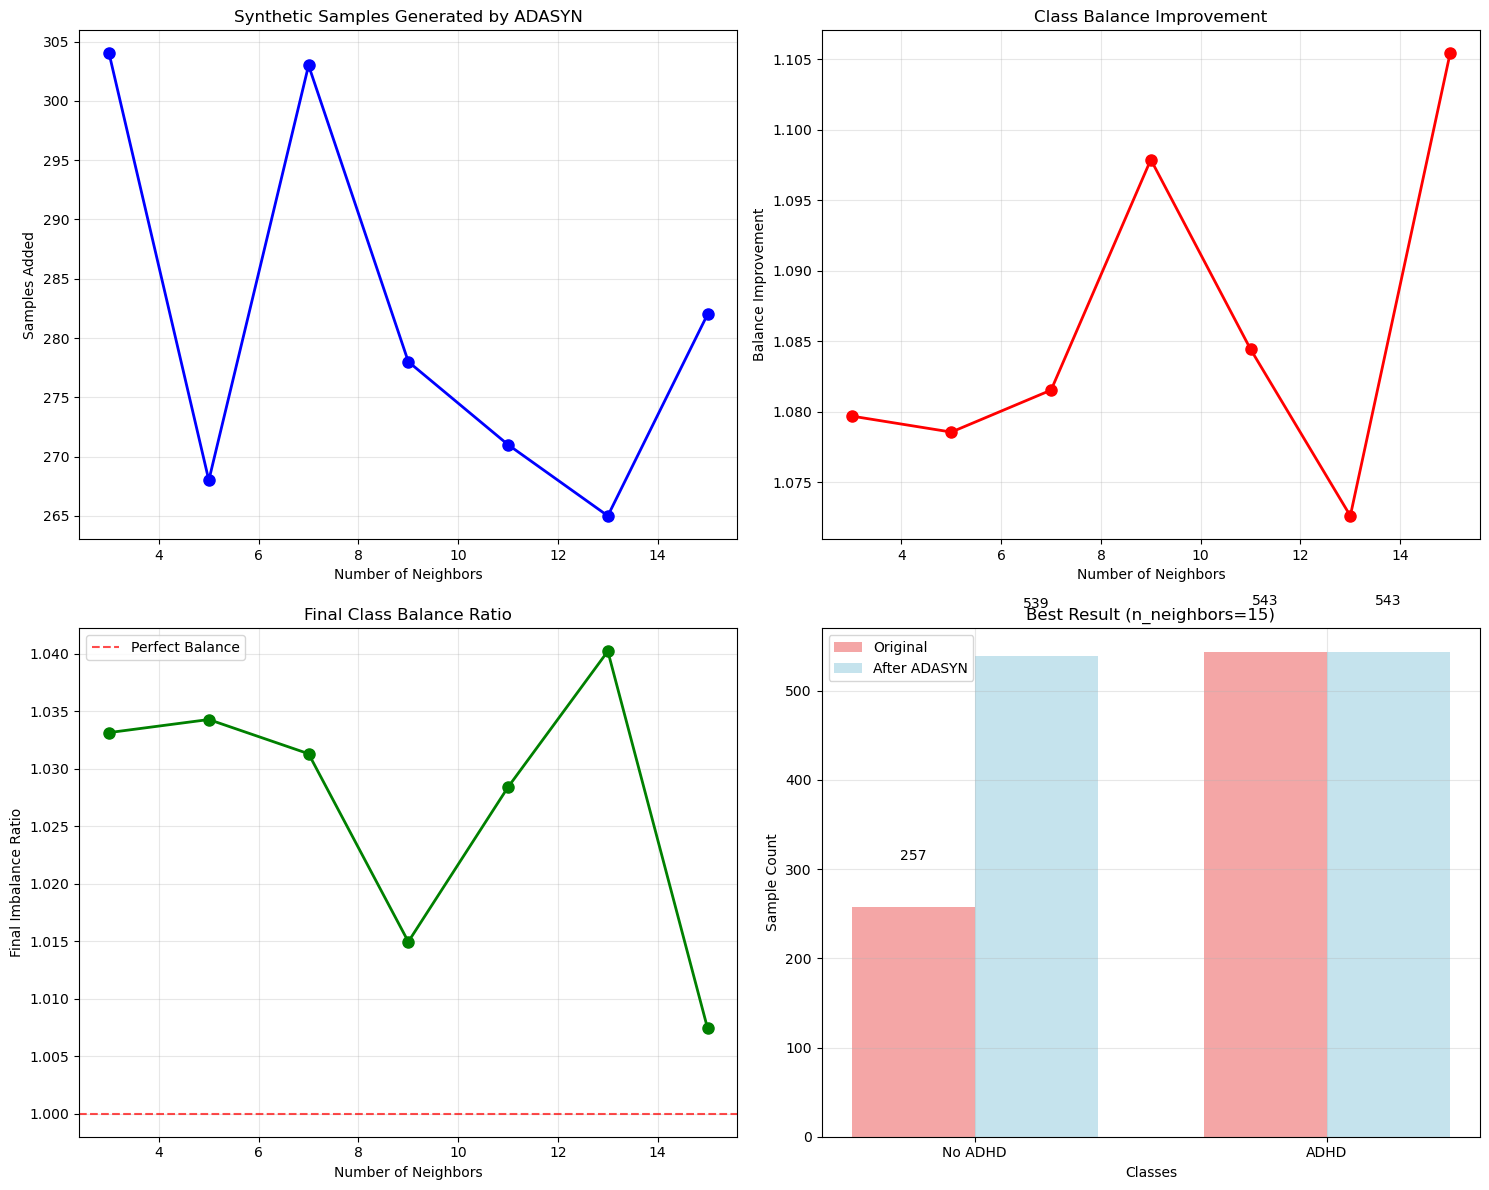


   🏆 BEST NEIGHBOR VALUES:
      📈 By Balance Improvement:
         1. n_neighbors=15: improvement=1.105
         2. n_neighbors=9: improvement=1.098
         3. n_neighbors=11: improvement=1.084
      ⚖️ By Final Balance (closest to 1:1):
         1. n_neighbors=15: ratio=1.007
         2. n_neighbors=9: ratio=1.015
         3. n_neighbors=11: ratio=1.028

STEP 5: Applying Optimal ADASYN
   🎯 Selected optimal n_neighbors: 15
      • Achieves ratio: 1.007:1
🎯 APPLYING OPTIMAL ADASYN (n_neighbors=15)
   📊 Original Distribution: Counter({1: 680, 0: 321})
   ✅ ADASYN Applied Successfully!
      • New Distribution: Counter({1: 680, 0: 661})
      • Samples Added: 340
      • Original Size: 1,001
      • New Size: 1,341
      • Size Increase: 34.0%
      • Original Imbalance Ratio: 2.118:1
      • New Imbalance Ratio: 1.029:1
      • Balance Improvement: 1.090

STEP 6: Saving Balanced Dataset
💾 SAVING BALANCED DATASET AND ARTIFACTS
   ✅ Balanced dataset saved: balanced_adhd_dataset.csv
   

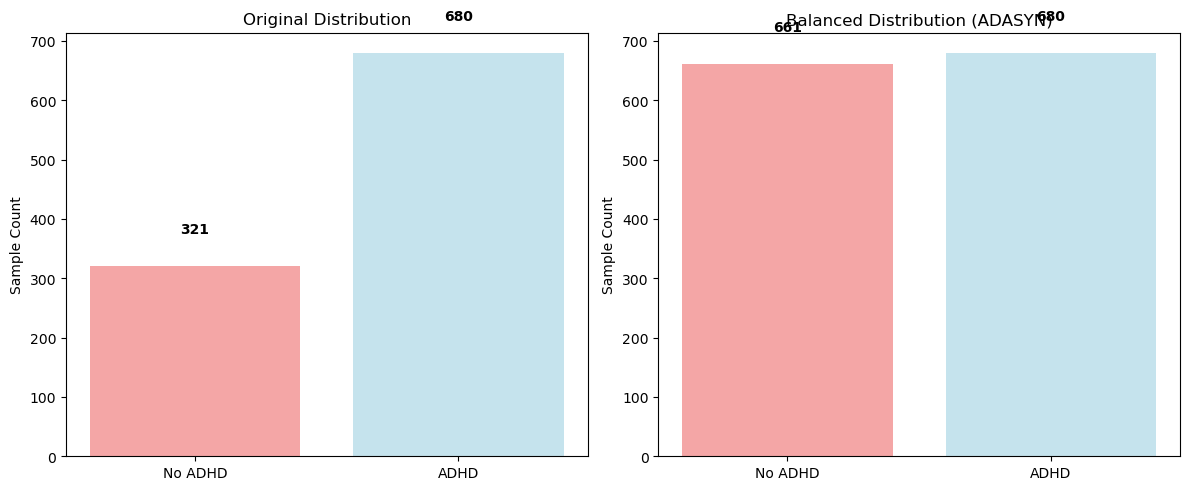


🎉 ADASYN BALANCING COMPLETE!
   📊 Final balanced dataset ready for modeling
   💾 All files saved and ready for use


In [31]:
# =============================================================================
# ADASYN IMPLEMENTATION WORKFLOW
# =============================================================================

# Step 1: Analyze current class imbalance

    # Step 2: Prepare data for ADASYN
print("\nSTEP 2: Preparing Data for ADASYN")
    
    # Separate features and target
X = df_processed.drop(columns=['ADHD_Outcome', 'participant_id'], errors='ignore')
y = df_processed['ADHD_Outcome']
    
print(f"   📊 Feature matrix shape: {X.shape}")
print(f"   🎯 Target vector shape: {y.shape}")
print(f"   📈 Features: {X.shape[1]}")
    
    # Step 3: Experiment with different neighbor values
print("\nSTEP 3: Experimenting with ADASYN Parameters")
    
experiment_results, X_train, X_test, y_train, y_test = experiment_adasyn_neighbors(
    X, y, 
    neighbor_range=(3, 16),  # Test neighbors from 3 to 15
    step=2,                  # Test every 2 values (3, 5, 7, 9, 11, 13, 15)
    random_state=42
    )
    
    # Step 4: Visualize experiment results
print("\nSTEP 4: Analyzing Experiment Results")
visualize_adasyn_experiments(experiment_results)
    
    # Step 5: Apply optimal ADASYN
print("\nSTEP 5: Applying Optimal ADASYN")
    
    # Find best neighbor value (closest to perfect balance)
successful_results = {k: v for k, v in experiment_results.items() if v.get('success', False)}
    
if successful_results:
    optimal_neighbors = min(successful_results.keys(), 
                            key=lambda k: abs(successful_results[k]['new_ratio'] - 1.0))
        
    print(f"   🎯 Selected optimal n_neighbors: {optimal_neighbors}")
    print(f"      • Achieves ratio: {successful_results[optimal_neighbors]['new_ratio']:.3f}:1")
        
        # Apply ADASYN to full dataset
    X_balanced, y_balanced, adasyn_model = apply_optimal_adasyn(
        X, y, 
        optimal_neighbors=optimal_neighbors,
        random_state=42
    )
        
        # Step 6: Save balanced dataset
    print("\nSTEP 6: Saving Balanced Dataset")
    df_balanced = save_balanced_dataset(
        df_processed, X_balanced, y_balanced, 
        feature_groups, processing_results
    )
        
        # Step 7: Final comparison visualization
    print("\nSTEP 7: Final Comparison")
        
    plt.figure(figsize=(12, 5))
        
        # Original distribution
    plt.subplot(1, 2, 1)
    original_counts = Counter(y)
    plt.bar(['No ADHD', 'ADHD'], 
               [original_counts[0], original_counts[1]], 
               color=['lightcoral', 'lightblue'], alpha=0.7)
    plt.title('Original Distribution')
    plt.ylabel('Sample Count')
    for i, count in enumerate([original_counts[0], original_counts[1]]):
        plt.text(i, count + 50, f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
        # Balanced distribution
    plt.subplot(1, 2, 2)
    balanced_counts = Counter(y_balanced)
    plt.bar(['No ADHD', 'ADHD'], 
            [balanced_counts[0], balanced_counts[1]], 
            color=['lightcoral', 'lightblue'], alpha=0.7)
    plt.title('Balanced Distribution (ADASYN)')
    plt.ylabel('Sample Count')
    for i, count in enumerate([balanced_counts[0], balanced_counts[1]]):
        plt.text(i, count + 50, f'{count:,}', ha='center', va='bottom', fontweight='bold')
        
    plt.tight_layout()
    plt.show()
        
    print(f"\n🎉 ADASYN BALANCING COMPLETE!")
    print(f"   📊 Final balanced dataset ready for modeling")
    print(f"   💾 All files saved and ready for use")
        
else:
    print("   ❌ No successful ADASYN experiments. Using original dataset.")
    df_balanced = df_processed
        


In [ ]:
# =============================================================================
# FEATURE GROUPING AND IDENTIFICATION
# =============================================================================

def identify_feature_groups(df):
    """
    Identify and categorize features for targeted preprocessing.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to categorize
    
    Returns:
    --------
    dict
        Dictionary containing feature groups
    """

    # Define feature groups based on column name patterns
    quant_cols = [col for col in df.columns if 
                  (col.startswith('APQ_') or col.startswith('SDQ_') or 
                   col.startswith('EHQ_') or col.startswith('ColorVision')) 
                  and col in df.columns]

    cat_cols = [col for col in df.columns if 
                (col.startswith('PreInt_') or col.startswith('Basic_') or 
                 col.startswith('Barratt_') or col.startswith('MRI_') or 
                 col == 'Sex_F') 
                and col in df.columns 
                and col not in ['participant_id', 'ADHD_Outcome']]

    conn_cols = [col for col in df.columns if 
                 col not in quant_cols + cat_cols + 
                 ['participant_id', 'ADHD_Outcome']]
    
    feature_groups = {
        'quantitative': quant_cols,
        'categorical': cat_cols,
        'connectome': conn_cols,
    }
    
    print(f" Feature Group Summary:")
    print(f" Quantitative features: {len(quant_cols):,}")
    print(f" Categorical features: {len(cat_cols):,}")
    print(f" Connectome features: {len(conn_cols):,}")
   
    

    return feature_groups

# Identify feature groups
feature_groups = identify_feature_groups(df)

 Feature Group Summary:
 Quantitative features: 17
 Categorical features: 11
 Connectome features: 19,900


In [ ]:
# =============================================================================
# PREPROCESSING FUNCTIONS
# =============================================================================

def standardize_quantitative_features(df, quant_cols):
    """
    Standardize quantitative features using StandardScaler.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to standardize
    quant_cols : list
        List of quantitative column names
    
    Returns:
    --------
    tuple
        (df_standardized, scaler) - Standardized dataset and fitted scaler
    """
    existing_quant = [col for col in quant_cols if col in df.columns]
    
    if existing_quant:
        scaler = StandardScaler()
        df[existing_quant] = scaler.fit_transform(df[existing_quant])
        return df, scaler
    else:
        print("   ⚠️ No quantitative features found to standardize")
        return df, None

def impute_missing_values(df, cols, method='knn', n_neighbors=5):
    """
    Impute missing values using specified method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with missing values
    cols : list
        Columns to impute
    method : str
        Imputation method ('knn', 'mean', 'median')
    n_neighbors : int
        Number of neighbors for KNN imputation
    
    Returns:
    --------
    tuple
        (df_imputed, imputer) - Imputed dataset and fitted imputer
    """
    existing_cols = [col for col in cols if col in df.columns]
    
    if existing_cols:
        missing_before = df[existing_cols].isnull().sum().sum()
        print(f" {missing_before:,} missing values in {len(existing_cols)} columns using {method.upper()}...")
        
        if method == 'knn':
            imputer = KNNImputer(n_neighbors=n_neighbors)
        else:
            raise ValueError(f"Unsupported imputation method: {method}")
            
        df[existing_cols] = imputer.fit_transform(df[existing_cols])
        
        # Verify imputation
        missing_after = df[existing_cols].isnull().sum().sum()
        print(f"  Missing values after imputation: {missing_after:,}")
        

        
        return df, imputer
    else:
        print(f"    No columns found to impute")
        return df, None

def encode_categorical_features(df, cat_cols):
    """
    One-hot encode categorical features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with categorical features
    cat_cols : list
        List of categorical column names
    
    Returns:
    --------
    tuple
        (df_encoded, encoder) - Encoded dataset and fitted encoder
    """
    existing_cat = [col for col in cat_cols if col in df.columns]
    
    if existing_cat:
        
        
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(df[existing_cat])
        
        # Create encoded dataframe
        encoded_df = pd.DataFrame(
            encoded, 
            columns=encoder.get_feature_names_out(existing_cat), 
            index=df.index
        )
        
        # Replace original categorical columns
        df = df.drop(columns=existing_cat)
        df = pd.concat([df, encoded_df], axis=1)
        
        print(f"Created {encoded_df.shape[1]} encoded features")
        
        
        
        return df, encoder
 

def apply_pca_to_connectome(df, conn_cols, n_components=10):
    """
    Apply PCA dimensionality reduction to connectome features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with connectome features
    conn_cols : list
        List of connectome column names
    n_components : int
        Number of PCA components to retain
    
    Returns:
    --------
    tuple
        (df_pca, pca_model) - Dataset with PCA features and fitted PCA model
    """
    existing_conn = [col for col in conn_cols if col in df.columns]
    
    if existing_conn and len(existing_conn) >= n_components:
        
        pca = PCA(n_components=n_components)
        conn_pca = pca.fit_transform(df[existing_conn])
        
        # Create PCA feature names
        pca_cols = [f'conn_{i+1}' for i in range(n_components)]
        conn_pca_df = pd.DataFrame(conn_pca, columns=pca_cols, index=df.index)
        
        # Replace original connectome columns
        df = df.drop(columns=existing_conn)
        df = pd.concat([df, conn_pca_df], axis=1)
        
        # Calculate explained variance
        explained_var = pca.explained_variance_ratio_
        total_var = explained_var.sum()
       
        print(f" Components: {n_components}")
        print(f" Total variance explained: {total_var:.2%}")
        print(f" Variance per component: {explained_var[:5].round(3)}")
        
       
        
        return df, pca
   

In [ ]:
# =============================================================================
# PREPROCESSING PIPELINE EXECUTION
# =============================================================================

def execute_preprocessing_pipeline(df, feature_groups):
    """
    Execute the complete preprocessing pipeline.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to preprocess
    feature_groups : dict
        Dictionary containing feature group definitions
    
    Returns:
    --------
    dict
        Processing results and fitted transformers
    """
   
    
    results = {}
    
    # 1. Standardize quantitative features
    df, scaler = standardize_quantitative_features(df, feature_groups['quantitative'])
    results['scaler'] = scaler
    
    # 2. Impute missing values (quantitative + categorical)
    impute_cols = feature_groups['quantitative'] + feature_groups['categorical']
    df, imputer = impute_missing_values(df, impute_cols, method='knn', n_neighbors=KNN_NEIGHBORS)
    results['imputer'] = imputer

    
    # 3. Apply PCA to connectome features
    df, pca_model = apply_pca_to_connectome(df, feature_groups['connectome'], n_components=PCA_COMPONENTS)
    results['pca'] = pca_model

    
    # 4. One-hot encode categorical features
    df, encoder = encode_categorical_features(df, feature_groups['categorical'])
    results['encoder'] = encoder
    
    return df, results

# Execute preprocessing pipeline
df_processed, processing_results = execute_preprocessing_pipeline(df, feature_groups)


print(f" Final dataset shape: {df_processed.shape}")

 906 missing values in 28 columns using KNN...


  Missing values after imputation: 0
 Components: 10
 Total variance explained: 19.34%
 Variance per component: [0.051 0.028 0.021 0.017 0.016]
Created 1131 encoded features
 Final dataset shape: (1001, 1160)


## Save preprocessed data 

In [ ]:
df.to_csv('processed_data.csv', index=False)

Text(0.5, 1.0, 'Balanced ADHD Outcome Distribution')

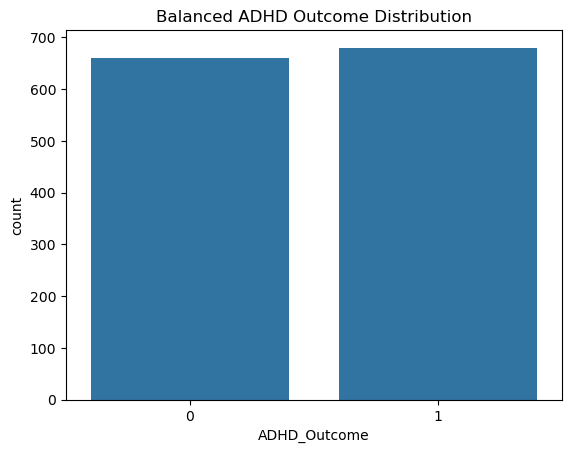

In [32]:
sns.countplot(x='ADHD_Outcome', data=df_balanced)
plt.title('Balanced ADHD Outcome Distribution')

# Done